<a href="https://colab.research.google.com/github/aditya-saurabh/generative-adversial-network/blob/master/conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [0]:
def define_discriminator(in_shape = (28, 28, 1), n_classes=10):
  in_label = Input(shape=(1,))
  li = Embedding(n_classes, 50)(in_label)

  li = Dense(in_shape[0]*in_shape[1])(li)

  li = Reshape((in_shape[0], in_shape[1], in_shape[2]))(li)

  in_img = Input(shape=in_shape)

  merge = Concatenate()([in_img, li])
  

  mi = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  mi = LeakyReLU(alpha=0.2)(mi)

  mi = Conv2D(128, (3,3), strides=(2,2), padding='same')(mi)
  mi = LeakyReLU(alpha=0.2)(mi)

  mi = Flatten()(mi)
  mi = Dropout(0.4)(mi)

  output = Dense(1, activation='sigmoid')(mi)

  model = Model(inputs=[in_img, in_label], outputs=output)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  return model


In [70]:
discriminator = define_discriminator()
discriminator.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 50)        500         input_41[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 1, 784)       39984       embedding_21[0][0]               
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 28, 28, 1)    0                                            
___________________________________________________________________________________________

In [0]:
def define_generator(latent_dim=100, n_classes=10):
  in_label = Input(shape=(1,))
  embedding = Embedding(n_classes, 50)(in_label)
  li = Dense(49)(embedding)
  
  li = Reshape((7,7,1))(li)

  in_img = Input(shape=(latent_dim,))
  img = Dense(128*7*7)(in_img)
  img = LeakyReLU(alpha=0.2)(img)
  img = Reshape((7,7,128))(img)

  merge = Concatenate()([img, li])
  conv = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  conv = LeakyReLU(alpha=0.2)(conv)

  conv = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(conv)
  conv = LeakyReLU(alpha=0.2)(conv)

  output = Conv2D(1, (7,7), strides=(1,1), padding='same')(conv)

  model = Model([in_img, in_label], output)

  return model


In [72]:
generator = define_generator(100, 10)
generator.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 6272)         633472      input_44[0][0]                   
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1, 50)        500         input_43[0][0]                   
___________________________________________________________________________________________

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

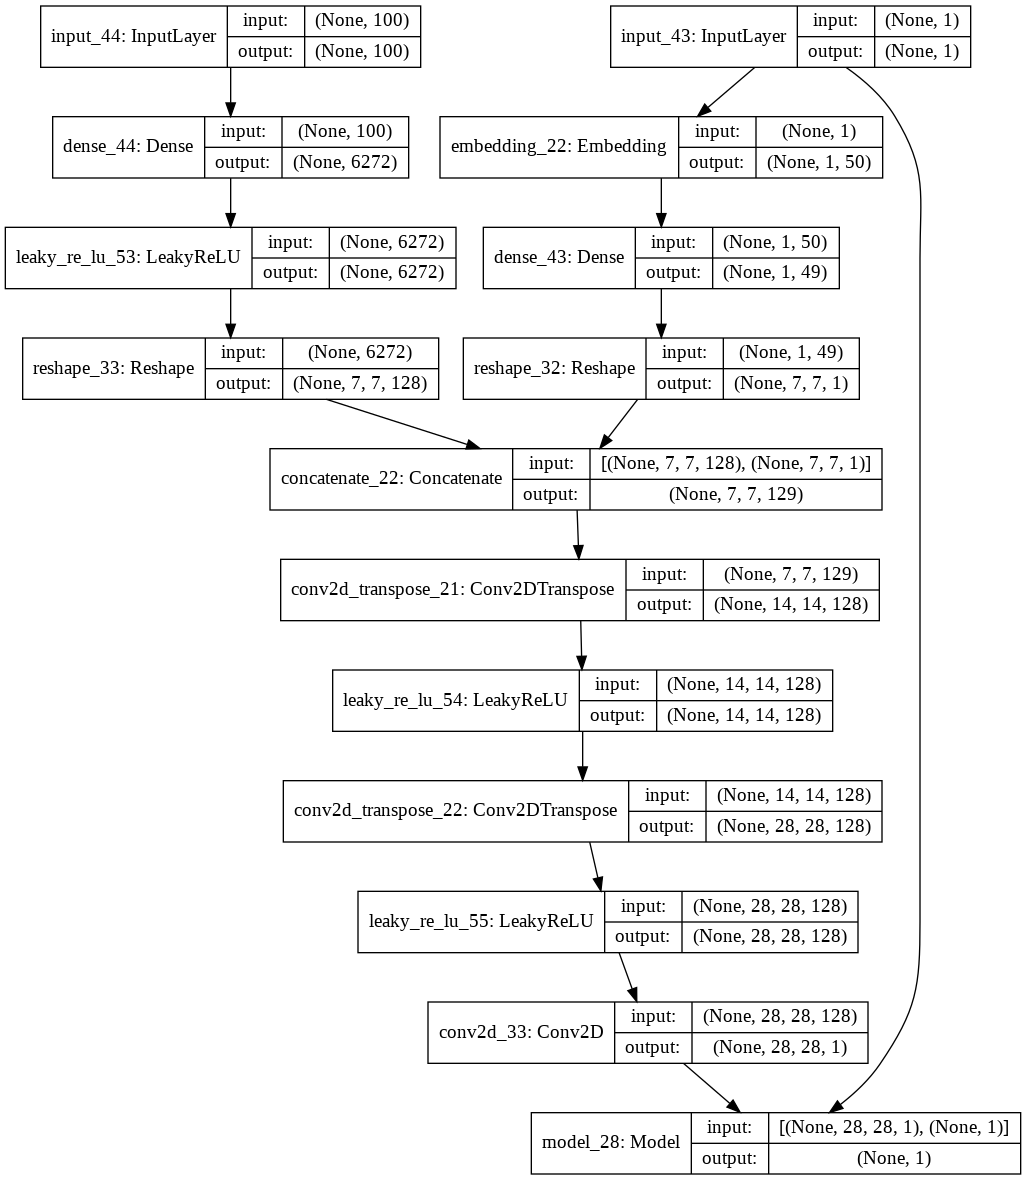

In [92]:
from keras.utils.vis_utils import plot_model
plot_model(gan, show_shapes=True, show_layer_names=True)

In [0]:
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [89]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Streaming output truncated to the last 5000 lines.
>10, 150/468, d1=0.467, d2=0.563 g=1.659
>10, 151/468, d1=0.633, d2=0.386 g=1.685
>10, 152/468, d1=0.424, d2=0.442 g=1.350
>10, 153/468, d1=0.405, d2=0.451 g=1.525
>10, 154/468, d1=0.408, d2=0.386 g=1.751
>10, 155/468, d1=0.386, d2=0.408 g=1.825
>10, 156/468, d1=0.592, d2=0.554 g=1.291
>10, 157/468, d1=0.531, d2=0.521 g=1.543
>10, 158/468, d1=0.557, d2=0.333 g=1.765
>10, 159/468, d1=0.482, d2=0.443 g=1.497
>10, 160/468, d1=0.433, d2=0.508 g=1.729
>10, 161/468, d1=0.453, d2=0.414 g=1.690
>10, 162/468, d1=0.508, d2=0.490 g=1.577
>10, 163/468, d1=0.624, d2=0.405 g=1.761
>10, 164/468, d1=0.446, d2=0.444 g=1.629
>10, 165/468, d1=0.376, d2=0.463 g=1.487
>10, 166/468, d1=0.631, d2=0.386 g=1.767
>10, 167/468, d1=0.495, d2=0.427 g=1.512
>10, 168/468, d1=0.390, d2=0.494 g=1.471
>10, 169/468, d1=0.557, d2=0.515 g=1.722
>10, 170/468, d1=0.443, d2=0.479 g=1.613
>10, 171/468, d1=0.578, d2=0.441 g=1.483
>10, 172/468, d1=0.496, d2=0.371 g=1.672
>10, 1

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


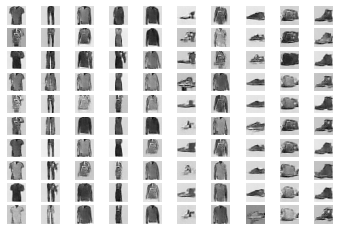

In [90]:

# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)